In [159]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [160]:
# Parameters assumed by paper

paper_params = {
    "r": 0.05,
    "a": 0.5,
    "b": 0.05,
    "theta": 0.025,
    "sigma": 0.08,
    "lambda": -0.5,
    "gamma": 0.01,
    "h": 10,
    "mu": 0
}

t = 0.05
T = 20
m = 365
n = 1000
delta_t = (T-t)/m

In [163]:
def increment_vas(rj, t, T, m, nj, pj, Jj, params):
    """
    Arguments:
    rj, float: rate from time step j
    params, dict: CIR model parameters
    nj, float: jth draw from N(0,1)
    pj, float: jth draw from Poisson(h*delta_t)
    Jj, float: jth draw from N(mu, lambda)
    Returns:
    rj1, float: rate at time step j+1 
    """
    delta_t = (T-t)/m
    theta = params["theta"]
    sigma = params["sigma"]
    a = params["a"]
    lambda_ = params["lambda"]
    
    time_step = (theta - a*rj - lambda_*sigma)*delta_t
    stoch_step = sigma*nj*np.sqrt(delta_t)
    jump_step = Jj*pj
    
    rj1 = rj + time_step + stoch_step + jump_step
    # rj1 = rj + time_step + stoch_step
    return max(rj1, 0)

In [164]:
def increment_cir(rj, t, T, m, nj, pj, Jj, params):
    """
    Arguments:
    rj, float: rate from time step j
    params, dict: CIR model parameters
    nj, float: jth draw from N(0,1)
    pj, float: jth draw from Poisson(h*delta_t)
    Jj, float: jth draw from N(mu, lambda)
    Returns:
    rj1, float: rate at time step j+1 
    """
    delta_t = (T-t)/m
    theta = params["theta"]
    sigma = params["sigma"]
    a = params["a"]
    lambda_ = params["lambda"]
    
    time_step = (theta - a*rj - lambda_*sigma*np.sqrt(rj))*delta_t
    stoch_step = sigma*np.sqrt(rj)*nj*np.sqrt(delta_t)
    jump_step = Jj*pj
    
    rj1 = rj + time_step + stoch_step + jump_step
    # rj1 = rj + time_step + stoch_step
    return max(rj1, 0)

In [165]:
def simulate_path(t, T, m, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    r = [params["r"]]
    ts = [t]
    h = params["h"]
    gamma = params["gamma"]
    mu = params["mu"]
    delta_t = (T-t)/m
    p = scipy.stats.poisson.rvs(h*delta_t, size=m)
    n = scipy.stats.norm.rvs(size=m)
    J = scipy.stats.norm.rvs(mu, gamma, size=m)
    for j in range(m):
        r.append(model_func(r[j], t, T, m, n[j], p[j], J[j], params))
        ts.append(ts[j] + delta_t)
    price = np.exp(-np.sum([rj*delta_t for rj in r]))
    return r, ts, price

In [166]:
def simulate_price(t, T, m, n, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    prices = np.empty(n, dtype=np.float)
    for i in range(n):
        r, ts, price = simulate_path(t, T, m, model_func, params)
        prices[i] = price
    return np.mean(prices)

In [167]:
def plot_price_curve(t, T, m, n, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    Ts = list(range(1, T+1))
    Prices = np.empty(len(Ts), dtype=np.float)
    i = 0
    for T in Ts:
        Prices[i] = simulate_price(t, T, m, n, model_func, params)
        i += 1
    plt.scatter(Ts, Prices)
    plt.show()

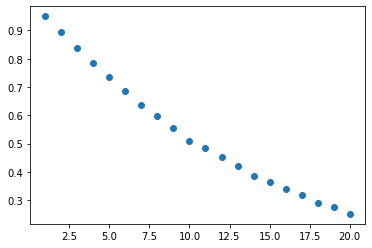

In [168]:
np.random.seed(929469047)
plot_price_curve(t, T, m, n, increment_cir, paper_params)

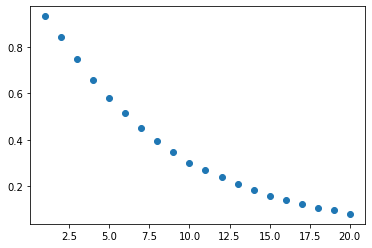

In [169]:
np.random.seed(929469047)
plot_price_curve(t, T, m, n, increment_vas, paper_params)